# Beam Blockage calculations (Aparri Radar)

Author: [Irene Crisologo](http://philippineradarnetwork.wordpress.com)

This notebook is part of a collection of notebooks that demonstrates how to determine and plot the beam blockage map for the different radars in the Philippines.

More specifically, this will demonstrate how to determine the beam blockage map for the **Aparri** radar. 

In [1]:
import wradlib as wrl
import netCDF4 as nc
import matplotlib.pyplot as pl
import matplotlib as mpl
import warnings
warnings.filterwarnings('ignore')
try:
    get_ipython().magic("matplotlib inline")
except:
    pl.ion()
import numpy as np
import datetime as dt

ImportError: No module named wradlib

In [2]:
def read_JBirds(fname):
    f = open(fname, 'rb')
    r = np.fromfile(f, dtype='B')
    f.close()

    # Raw Data Header
    #   ignore first 96 members
    raw_data_header = r[96:352]
    # Sweep Data
    data = np.reshape(r[352:],(360,352))

    # Sweep Header
    sweep_header = data[:,:32]
    sweep_data = data[:,32:] * 0.3125 # 0.3125dBZ per member value

    # collect attributes from header
    attrs = {}

    # location
    loc = raw_data_header[1]
    if loc == int('40',16):
        attrs['Location'] = 'Virac'
        attrs['sitecoords'] = (124.32, 13.62, 625)
        attrs['Latitude'] = 13.62
        attrs['Longitude'] = 124.32
    elif loc == int('41',16):
        attrs['Location'] = 'Aparri'
        attrs['sitecoords'] = (121.62, 18.35, 47)
        attrs['Latitude'] = 18.35
        attrs['Longitude'] = 121.62
    elif loc == int('42',16):
        attrs['Location'] = 'Guiuan'
        attrs['sitecoords'] = (125.75, 11.04, 60)
        attrs['Latitude'] = 11.04
        attrs['Longitude'] = 125.75
    else:
        attrs['Location'] = 'other'
    # Data type
    dattype = raw_data_header[3]
    if dattype == int('75',16):
        attrs['Data Type'] = 'Doppler Velocity'
    elif dattype == int('76',16):
        attrs['Data Type'] = 'Spectrum Width'
    elif dattype == int('F1',16):
        attrs['Data Type'] = 'Reflectivity'
    else:
        attrs['Data Type'] = 'other'
    # Date Time
    datestr = ''.join([chr(f) for f in raw_data_header[8:24]])
    attrs['time'] = dt.datetime.strptime(datestr, '%Y.%m.%d.%H.%M')
    # Response Status
    if raw_data_header[29] == 0:
        attrs['Response Status'] = 'Normal'
    else:
        attrs['Response Status'] = 'Error'
    # Step no.
    attrs['Step number'] = raw_data_header[42]
    ## Elevation
    #attrs['Elevation'] = raw_data_header[44]*360./(2**16)
    # Z-Relation-B
    attrs['Z-Relation B'] = raw_data_header[52]/100.
    # Z-Relation-Beta
    attrs['Z-Relation Beta'] = raw_data_header[54]/100.

    # get attributes from filename
    elev = int(fname[::-1][18:22][::-1])
    if fname[::-1][16:18][::-1] == 'P1':
        attrs['Elevation'] = elev / 10.
    elif fname[::-1][16:18][::-1] == 'P2':
        attrs['Elevation'] = elev / 100.
    attrs['Sweep'] = int(fname[::-1][13:15][::-1])

    attrs['MissingData'] = 255 * 0.3125
    if int(attrs['Sweep']) > 4:
        attrs['r'] = np.linspace(625,200000,320)
    else:
        attrs['r'] = np.linspace(1375,440000,320)
    attrs['az'] = np.linspace(1,360,360)

    data = np.where(sweep_data==attrs['MissingData'], np.nan, sweep_data)
    
    return data, attrs

In [3]:
radarshortname = 'apa'

fname = '../phirad-data/radars/aparri/aparri_201605021300_Z_EL+0000P1_01_13.bin.polar'  # elev = 0.0

data, attrs = read_JBirds(fname)
print np.max(attrs['r'])

440000.0


In [4]:
# setup radar specs 
sitecoords = attrs['sitecoords']
nrays = len(attrs['az'])
nbins = len(attrs['r'])
nbins=200
el = attrs['Elevation']
#el = 1.5
bw = 1.0
range_res = 625
print sitecoords
print el
print nbins, nrays

(121.62, 18.35, 47)
0.0
200 360


In [5]:
r = np.arange(nbins) * range_res
beamradius = wrl.util.half_power_radius(r, bw)

In [6]:
coord = wrl.georef.sweep_centroids(nrays, range_res, nbins, el)
lon, lat, alt = np.array(
    wrl.georef.polar2lonlatalt_n(coord[..., 0], np.degrees(coord[..., 1]),
                                 coord[..., 2], sitecoords))
polcoords = np.dstack((lon, lat))
print("lon,lat,alt:", lon.shape, lat.shape, alt.shape)

# get radar bounding box lonlat
lonmin = np.min(lon)
lonmax = np.max(lon)
latmin = np.min(lat)
latmax = np.max(lat)
rlimits = [lonmin, latmin, lonmax, latmax]
print("radar bounding box:", rlimits)

('lon,lat,alt:', (360L, 200L), (360L, 200L), (360L, 200L))
('radar bounding box:', [120.43960508581857, 17.229642790486313, 122.80037184531554, 19.47035707112909])


In [7]:
latmax

19.47035707112909

### Read DEM Raster Data

In [8]:
# read raster data
rastercoords, rastervalues = wrl.io.read_raster_data('../phirad-data/dem/SRTM_APA.tif')

# apply radar bounding box to raster data
# this actually cuts out the interesting box from rasterdata
ind = wrl.util.find_bbox_indices(rastercoords, rlimits)
rastercoords = rastercoords[ind[1]:ind[3], ind[0]:ind[2], ...]
rastervalues = rastervalues[ind[1]:ind[3], ind[0]:ind[2]]

# map rastervalues to polar grid points
polarvalues = wrl.ipol.cart2irregular_spline(rastercoords, rastervalues,
                                             polcoords, order=3,
                                             prefilter=False)

print(polarvalues.shape)

(360L, 200L)


In [9]:
rastercoords.shape

(2691L, 2834L, 2L)

In [10]:
PBB = wrl.qual.beam_block_frac(polarvalues, alt, beamradius)
PBB = np.ma.masked_invalid(PBB)
print(PBB.shape)

(360L, 200L)


In [11]:
# calculate cumulative beam blockage CBB
ind = np.nanargmax(PBB, axis=1)
CBB = np.copy(PBB)
for ii, index in enumerate(ind):
    CBB[ii, 0:index] = PBB[ii, 0:index]
    CBB[ii, index:] = PBB[ii, index]

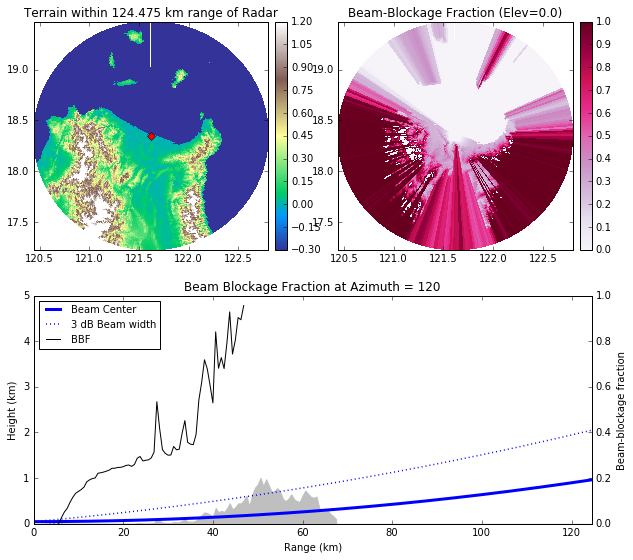

In [13]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
# plotting the stuff
fig = pl.figure(figsize=(10, 9))

# create subplots
ax1 = pl.subplot2grid((2, 2), (0, 0))
ax2 = pl.subplot2grid((2, 2), (0, 1))
ax3 = pl.subplot2grid((2, 2), (1, 0), colspan=2, rowspan=1)

# azimuth angle
angle = 120

# plot terrain
dem = ax1.pcolormesh(lon, lat, polarvalues / 1000., cmap=mpl.cm.terrain,
                     vmin=-0.3, vmax=1.2)
ax1.plot(sitecoords[0], sitecoords[1], 'rD')
ax1.set_title(
    'Terrain within {0} km range of Radar'.format(np.max(r / 1000.) + 0.1))
# colorbar
div1 = make_axes_locatable(ax1)
cax1 = div1.append_axes("right", size="5%", pad=0.1)
fig.colorbar(dem, cax=cax1)
# limits

ax1.set_xlim(lonmin, lonmax)
ax1.set_ylim(latmin, latmax)
ax1.set_aspect('auto')

# plot CBB on ax2
cbb = ax2.pcolormesh(lon, lat, CBB, cmap=mpl.cm.PuRd, vmin=0, vmax=1)
ax2.set_title('Beam-Blockage Fraction (Elev=%s)'%el)
div2 = make_axes_locatable(ax2)
cax2 = div2.append_axes("right", size="5%", pad=0.1)
# colorbar
fig.colorbar(cbb, cax=cax2)
# limits
ax2.set_xlim(lonmin, lonmax)
ax2.set_ylim(latmin, latmax)
ax2.set_aspect('auto')

# plot single ray terrain profile on ax3
bc, = ax3.plot(r / 1000., alt[angle, :] / 1000., '-b',
               linewidth=3, label='Beam Center')
b3db, = ax3.plot(r / 1000., (alt[angle, :] + beamradius) / 1000., ':b',
                 linewidth=1.5, label='3 dB Beam width')
ax3.plot(r / 1000., (alt[angle, :] - beamradius) / 1000., ':b')
ax3.fill_between(r / 1000., 0.,
                 polarvalues[angle, :] / 1000.,
                 color='0.75')
ax3.set_xlim(0., np.max(r / 1000.) + 0.1)
ax3.set_ylim(0., 5)
ax3.set_xlabel('Range (km)')
ax3.set_ylabel('Height (km)')
ax3.set_title('Beam Blockage Fraction at Azimuth = %s' %angle)

axb = ax3.twinx()
bbf, = axb.plot(r / 1000., CBB[angle, :], '-k',
                label='BBF')
axb.set_ylabel('Beam-blockage fraction')
axb.set_ylim(0., 1.)
axb.set_xlim(0., np.max(r / 1000.) + 0.1)

legend = ax3.legend((bc, b3db, bbf), ('Beam Center', '3 dB Beam width', 'BBF'),
                    loc='upper left', fontsize=10)

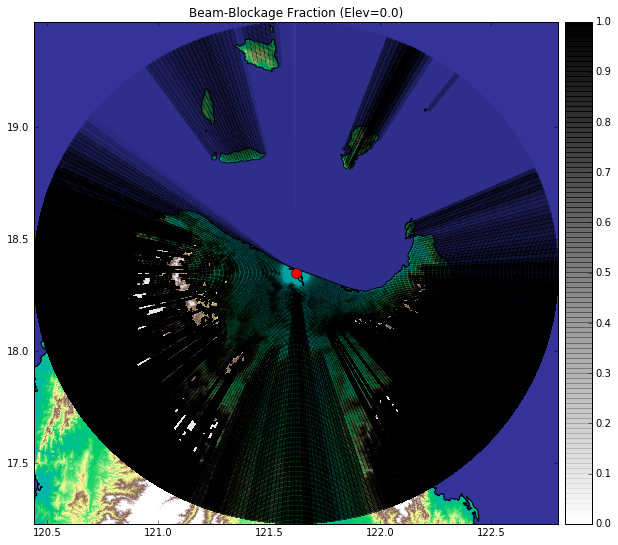

In [15]:
# Read shapefile for overlay
PATH_Ph_shapefile = '../phirad-data/shapefiles/Country/Country.shp'
dataset, inLayer = wrl.io.open_shape(PATH_Ph_shapefile)
borders, keys = wrl.georef.get_shape_coordinates(inLayer)

raster_lon = rastercoords[...,...,0]
raster_lat = rastercoords[...,...,1]

import matplotlib.colors as mcolors

# set up a linear colormap which is red and only changes alpha
# (1,0,0,1) --> (1,0,0,0) 
colors = [(0,0,0,1-i) for i in np.linspace(1,0,3)]
cmap = mcolors.LinearSegmentedColormap.from_list('mycmap', colors, N=100)

fig = pl.figure(figsize=(10, 9))
ax1 = pl.subplot(111)

pl.plot(sitecoords[0],sitecoords[1],'ro',ms=10)
dem = ax1.pcolormesh(raster_lon, raster_lat, rastervalues / 1000., cmap=mpl.cm.terrain,
                     vmin=-0.3, vmax=1.2)
shade = np.empty_like(CBB)
shade[:,:] = 0.1
sh = ax1.contourf(lon, lat, shade, cmap=cmap, vmin=0, vmax=1)
cbb = ax1.pcolormesh(lon, lat, CBB, cmap=cmap, vmin=0, vmax=1)
wrl.vis.add_lines(ax1, borders, color='black', lw=1.)
ax1.set_title('Beam-Blockage Fraction (Elev=%s)'%el)
div1 = make_axes_locatable(ax1)
cax1 = div1.append_axes("right", size="5%", pad=0.1)
# colorbar
fig.colorbar(cbb, cax=cax1)
# limits
ax1.set_xlim(lonmin, lonmax)
ax1.set_ylim(latmin, latmax)
ax1.set_aspect('auto')
#pl.savefig(radarshortname+'.png')